In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit, KFold
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
pd.set_option("display.max_rows",None,'display.max_colwidth',10000,'display.max_columns',10000)
from collections import Counter

In [2]:
booksInformation = pd.read_csv('Books Information.csv')
genresMapping = pd.read_csv('Genres Mapping.csv')
userData = pd.read_csv('User Data.csv')
wordsInbooksData = pd.read_csv('Words in Books Data.csv')
wordsMapping = pd.read_csv('Words Mapping.csv')
subSamp = pd.read_csv('Example Submission.csv')

In [6]:
# Index(['User ID', 'User Difficulty Choice', 'User Read Books (2017)',
#        'User Read Books (2018)', 'Average Rating (2017)'],
#       dtype='object')

# Index(['Book ID', 'Book Genre', 'Barcode', 'Difficulty (Reader suggested)',
#        'Number Of Words', 'Price (2017)', 'Price (2018)', 'Most Sold At',
#        'Number Sold'],
#       dtype='object')

In [3]:
def nb_of_books(a):
    temp = list(map(int,a.split(',')))
    return len(temp)
'''

 b = (An + rating)/m+n
'''
def aver_of_price(a):
    temp = list(map(int,a.split(',')))
    total = 0
    for i in temp:
        total += booksInformation.loc[booksInformation['Book ID'] == i,'Price (2017)'].values[0]
    return total/len(temp)

loca = list(booksInformation['Most Sold At'].unique())
def perchase_loc(a): #购买地点?? 
    temp = list(map(int,a.split(',')))
    lt = []
    for i in temp:
        lt.append(booksInformation.loc[booksInformation['Book ID'] == i,'Most Sold At'].values[0])
    temp_1 = 0 
    for k in lt:       
        if lt.count(k) > temp_1:           
            max_str = k            
            temp_1 = lt.count(k) 
    return loca.index(max_str)

def difficult_sum(a): #难度
    temp = list(map(int,a.split(',')))
    total = 0
    for i in temp:
        total += booksInformation.loc[booksInformation['Book ID'] == i,'Difficulty (Reader suggested)'].values[0]
    return total/len(temp)

def num_sold(a):
    temp = list(map(int,a.split(',')))
    total = 0
    for i in temp:
        total += booksInformation.loc[booksInformation['Book ID'] == i,'Number Sold'].values[0]
    return total

def total_words(a):
    temp = list(map(int,a.split(',')))
    total = 0
    for i in temp:
        total += booksInformation.loc[booksInformation['Book ID'] == i,'Number Of Words'].values[0]
    return total/len(temp)

def max_genre(a):
    temp = list(map(int,a.split(',')))
    lt = []
    for i in temp:
        lt.append(booksInformation.loc[booksInformation['Book ID'] == i,'Book Genre'].values[0])
    temp_1 = 0 
    for k in lt:       
        if lt.count(k) > temp_1:           
            max_str = k            
            temp_1 = lt.count(k) 
    return max_str
def genre_pick(a):
    temp = list(map(int,a.split(',')))
    lt = []
    for i in temp:
        lt.append(booksInformation.loc[booksInformation['Book ID'] == i,'Difficulty (Reader suggested)'].values[0])
    return lt

In [4]:
userData['User Difficulty Choice'] = userData['User Difficulty Choice'].replace('Not specified',0)

In [5]:
test = pd.DataFrame() 
test['User ID']= userData['User ID']
test['nb_of_books'] = userData['User Read Books (2018)'].apply(nb_of_books)
test['average_price'] = userData['User Read Books (2018)'].apply(aver_of_price)
# test['location'] = userData['User Read Books (2018)'].apply(perchase_loc)
test['diff_sum'] = userData['User Read Books (2018)'].apply(difficult_sum)
test['num_of_sold'] = userData['User Read Books (2018)'].apply(num_sold)
test['total_words'] = userData['User Read Books (2018)'].apply(total_words)
test['User Difficulty Choice'] = userData['User Difficulty Choice']
test['max_genre'] = userData['User Read Books (2018)'].apply(max_genre)

In [6]:
userData['nb_of_books'] = userData['User Read Books (2017)'].apply(nb_of_books)
userData['average_price'] = userData['User Read Books (2017)'].apply(aver_of_price)
# userData['location'] = userData['User Read Books (2017)'].apply(perchase_loc)
userData['diff_sum'] = userData['User Read Books (2017)'].apply(difficult_sum)
userData['num_of_sold'] = userData['User Read Books (2017)'].apply(num_sold)
userData['total_words'] = userData['User Read Books (2017)'].apply(total_words)
userData['max_genre'] = userData['User Read Books (2017)'].apply(max_genre)
userData.head()

,User ID,User Difficulty Choice,User Read Books (2017),User Read Books (2018),Average Rating (2017),nb_of_books,average_price,diff_sum,num_of_sold,total_words,max_genre
0,ID790145788,1,6254,7180,3.115447,1,34.506476,2.000000,3262,4522.000000,17
1,ID646234447,0,"5854, 5676, 7265, 6051","5729, 5279, 6242, 5519, 5251",3.157876,4,25.331126,4.750000,8838,2943.750000,0
2,ID86918707,5,5815,"6372, 6697",1.512284,1,25.963430,4.000000,3037,450.000000,4
3,ID404262345,2,"6969, 7002, 5761","5023, 6412, 6124",3.641681,3,15.239712,3.000000,3666,3065.000000,19
4,ID267634255,4,"7908, 7585, 7655, 5013, 5352, 7753, 5793","7915, 7884, 7404, 6022, 6589, 6543, 5450, 6848",2.506743,7,24.531754,3.714286,13458,2287.285714,14


In [12]:
# for i in range(userData.shape[0]):
#     print(i)
#     a = userData.loc[i,'User Read Books (2017)']
#     temp = list(map(int,a.split(',')))
#     for j in temp:
#         userData.loc[i,str(booksInformation.loc[booksInformation['Book ID'] == j,'Book Genre'].values[0])] += 1
    

In [8]:
no_use = ['User Read Books (2017)','User Read Books (2018)']

In [9]:
train = userData.drop(no_use,axis = 1)

In [10]:
X = train.drop(['User ID','Average Rating (2017)'], axis=1)
y = train['Average Rating (2017)']
X_test = test.drop(['User ID'],axis = 1)
tscv = TimeSeriesSplit(n_splits=10)

In [11]:
X['User Difficulty Choice'] = X['User Difficulty Choice'].astype(float)
X_test['User Difficulty Choice'] = X_test['User Difficulty Choice'].astype(float)

In [12]:
X = X.drop(['nb_of_books'], axis=1)
X_test = X_test.drop(['nb_of_books'], axis=1)

In [13]:
params = {"objective" : "regression", "metric" : "rmse", "max_depth": 8, "min_child_samples": 13, "reg_alpha": 0.2, "reg_lambda": 0.2,
        "num_leaves" : 56, "learning_rate" : 0.05}
n_fold = 10
folds = KFold(n_splits=n_fold, shuffle=False, random_state=1234)
################################################
model = lgb.LGBMRegressor(**params, n_estimators = 126)

In [14]:
prediction = np.zeros(test.shape[0])
for fold_n, (train_index, test_index) in enumerate(folds.split(X)):
    print('Fold:', fold_n)
    X_train, X_valid = X.iloc[train_index], X.iloc[test_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[test_index]
    
#####################################
    model.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_valid, y_valid)],categorical_feature= ['max_genre','User Difficulty Choice'],eval_metric='rmse',
            verbose=200, early_stopping_rounds=100)    
    y_pred = model.predict(X_test, num_iteration=model.best_iteration_,categorical_feature= ['max_genre','User Difficulty Choice'])
    prediction += y_pred
#########################################
prediction /= n_fold

Fold: 0
Training until validation scores don't improve for 100 rounds.


C:\Users\Yichen\Anaconda3\lib\site-packages\lightgbm\basic.py:1161: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is ['User Difficulty Choice', 'max_genre']
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Did not meet early stopping. Best iteration is:
[126]	training's rmse: 1.49715	valid_1's rmse: 1.73855
Fold: 1
Training until validation scores don't improve for 100 rounds.


C:\Users\Yichen\Anaconda3\lib\site-packages\lightgbm\basic.py:1161: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is ['User Difficulty Choice', 'max_genre']
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Did not meet early stopping. Best iteration is:
[126]	training's rmse: 1.48141	valid_1's rmse: 1.84048
Fold: 2
Training until validation scores don't improve for 100 rounds.


C:\Users\Yichen\Anaconda3\lib\site-packages\lightgbm\basic.py:1161: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is ['User Difficulty Choice', 'max_genre']
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Did not meet early stopping. Best iteration is:
[126]	training's rmse: 1.49145	valid_1's rmse: 1.73789
Fold: 3
Training until validation scores don't improve for 100 rounds.


C:\Users\Yichen\Anaconda3\lib\site-packages\lightgbm\basic.py:1161: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is ['User Difficulty Choice', 'max_genre']
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Did not meet early stopping. Best iteration is:
[126]	training's rmse: 1.50179	valid_1's rmse: 1.75316
Fold: 4
Training until validation scores don't improve for 100 rounds.


C:\Users\Yichen\Anaconda3\lib\site-packages\lightgbm\basic.py:1161: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is ['User Difficulty Choice', 'max_genre']
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Did not meet early stopping. Best iteration is:
[126]	training's rmse: 1.47344	valid_1's rmse: 1.77472
Fold: 5
Training until validation scores don't improve for 100 rounds.


C:\Users\Yichen\Anaconda3\lib\site-packages\lightgbm\basic.py:1161: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is ['User Difficulty Choice', 'max_genre']
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Did not meet early stopping. Best iteration is:
[126]	training's rmse: 1.48706	valid_1's rmse: 1.75979
Fold: 6
Training until validation scores don't improve for 100 rounds.


C:\Users\Yichen\Anaconda3\lib\site-packages\lightgbm\basic.py:1161: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is ['User Difficulty Choice', 'max_genre']
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Did not meet early stopping. Best iteration is:
[126]	training's rmse: 1.48039	valid_1's rmse: 1.83217
Fold: 7
Training until validation scores don't improve for 100 rounds.


C:\Users\Yichen\Anaconda3\lib\site-packages\lightgbm\basic.py:1161: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is ['User Difficulty Choice', 'max_genre']
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Did not meet early stopping. Best iteration is:
[126]	training's rmse: 1.491	valid_1's rmse: 1.73534
Fold: 8
Training until validation scores don't improve for 100 rounds.


C:\Users\Yichen\Anaconda3\lib\site-packages\lightgbm\basic.py:1161: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is ['User Difficulty Choice', 'max_genre']
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Did not meet early stopping. Best iteration is:
[126]	training's rmse: 1.48769	valid_1's rmse: 1.77322
Fold: 9
Training until validation scores don't improve for 100 rounds.


C:\Users\Yichen\Anaconda3\lib\site-packages\lightgbm\basic.py:1161: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is ['User Difficulty Choice', 'max_genre']
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Did not meet early stopping. Best iteration is:
[126]	training's rmse: 1.49341	valid_1's rmse: 1.74599


In [15]:
prediction

array([4.35115872, 3.6526859 , 3.45299567, ..., 3.48325111, 3.64450079,
       3.97709821])

In [16]:
new_sub = pd.DataFrame()
new_sub['prediction'] = prediction
new_sub['total_nb_book_2018'] = userData['User Read Books (2018)'].apply(nb_of_books)
new_sub['total_nb_book_2017'] = userData['User Read Books (2017)'].apply(nb_of_books)
new_sub['rating_2017'] = userData['Average Rating (2017)']
new_sub['fin_pre'] = (1.5*new_sub['total_nb_book_2017']*new_sub['rating_2017']+
                      0.5*new_sub['total_nb_book_2018']*new_sub['prediction'])/(new_sub['total_nb_book_2017']+new_sub['total_nb_book_2018'])

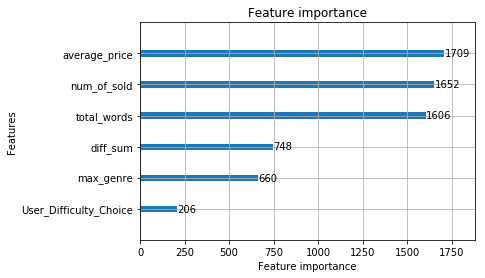

In [17]:
lgb.plot_importance(model, max_num_features=30);

adjust parameters

In [ ]:
data_train = lgb.Dataset(X, y, silent=True)
cv_results = lgb.cv(params, data_train, num_boost_round=1000, nfold=10, stratified=False, shuffle=True, metrics='rmse',     
                    early_stopping_rounds=50, verbose_eval=50, show_stdv=True, seed=0) 
print('best n_estimators:', len(cv_results['rmse-mean'])) 
print('best cv score:', cv_results['rmse-mean'][-1])

In [46]:
from sklearn.model_selection import GridSearchCV
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=56, learning_rate=0.05, n_estimators=126, 
                              max_depth=8,metric='rmse', bagging_fraction = 0.8,feature_fraction = 0.8) 
params_test1={'max_depth': range(6,10,2), 'num_leaves':range(50,70,2) } 
gsearch1 = GridSearchCV(estimator=model_lgb, param_grid=params_test1, scoring='neg_mean_squared_error', cv=5, verbose=1, n_jobs=4)

In [ ]:
gsearch1.fit(X,y) 
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

In [ ]:
params_test3={'min_child_samples': [10,11,12,13,14],'min_child_weight':[0.00001, 0.0001]} 
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=56, learning_rate=0.05, n_estimators=77, 
                              max_depth=8,metric='rmse', bagging_fraction = 0.8,feature_fraction = 0.8) 
gsearch3 = GridSearchCV(estimator=model_lgb, param_grid=params_test3, scoring='neg_mean_squared_error',
                        cv=5, verbose=1, n_jobs=4) 
gsearch3.fit(X, y) 
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

output

In [19]:
submission = test[['User ID']].copy()
submission.loc[:, 'Average Rating (2018)'] = new_sub['fin_pre']
submission["Average Rating (2018)"] = submission["Average Rating (2018)"].apply(lambda x : 
                                                                                0.0 if x < 0 and x > 10 else x)
submission["Average Rating (2018)"] = submission["Average Rating (2018)"].fillna(0.0)
grouped_test = submission[['User ID', "Average Rating (2018)"]]
grouped_test.to_csv('lgb.csv',index=False)